In [ ]:
# %pip install pandas numpy uvicorn fastapi pydantic cuda-toolkit==12.8 nvidia-cudnn-cu12==9.7.0.66 tf-nightly keras-nlp

In [2]:
from IPython.display import display, Markdown

from pandas import DataFrame, Series
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# TensorFlow et Keras
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import keras
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers import TextVectorization
import keras_nlp

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")



TensorFlow version: 2.19.1
Keras version: 3.12.0
KerasNLP version: 0.24.0


In [3]:
original_df: DataFrame = pd.read_parquet('https://huggingface.co/api/datasets/textdetox/multilingual_toxicity_dataset/parquet/default/fr/0.parquet')

In [4]:
df = original_df.sample(frac=1)
df.head(5).reset_index(drop=True)

,text,toxic
0,n hesitez pas a utiliser le bouton Prévisualis...,0
1,Je vais te les faire bouffer en salade avec ta...,1
2,C'est vrai que les parisiennes ont les têtes d...,1
3,C’est elle qui a conduit à la situation « post...,0
4,"En fait, ils ont repris les codes de com du FN...",0


# EDA et traitement des données

In [5]:
# Recherche d'éléments manquants
df_notna_count = len(df)
df.dropna(inplace=True)
print(f"{len(df)}/{df_notna_count} messages restants après retrait d'éventuels manque dans les données ou les labels")

5000/5000 messages restants après retrait d'éventuels manque dans les données ou les labels


In [6]:
from tensorflow import Tensor

@keras.saving.register_keras_serializable()
def custom_standardisation(t: Tensor) -> Tensor:
    # https://github.com/google/re2/wiki/Syntax
    # Remplacement manuel des lettres accentuées
    t = tf.strings.regex_replace(t, "[éèêë]", "e")
    t = tf.strings.regex_replace(t, "[ÉÈÊË]", "E")
    t = tf.strings.regex_replace(t, "[àâä]", "a")
    t = tf.strings.regex_replace(t, "[ÀÂÄ]", "A")
    t = tf.strings.regex_replace(t, "[îï]", "i")
    t = tf.strings.regex_replace(t, "[ÎÏ]", "I")
    t = tf.strings.regex_replace(t, "[ôö]", "o")
    t = tf.strings.regex_replace(t, "[ÔÖ]", "O")
    t = tf.strings.regex_replace(t, "[ùûü]", "u")
    t = tf.strings.regex_replace(t, "[ÙÛÜ]", "U")
    t = tf.strings.regex_replace(t, "ç", "c")
    t = tf.strings.regex_replace(t, "Ç", "C")
    t = tf.strings.regex_replace(t, "ÿ", "y")
    t = tf.strings.regex_replace(t, "Ÿ", "Y")

    t = tf.strings.lower(t)
    t = tf.strings.regex_replace(t, r"[a-z]+://[^ ]+", "") # retrait d'url
    t = tf.strings.regex_replace(t, r"<[^>]+>", " ") # strip html tags

    t = tf.strings.regex_replace(t, r"\pP", "") # Retrait de poncutation
    t = tf.strings.regex_replace(t, r"\pS", "") # Retrait de Symboles
    t = tf.strings.regex_replace(t, r"[^\p{Latin} ]", "") # Retrait de poncutation
    
    t = tf.strings.regex_replace(t, r"(\b\w\b)", "") # retrait des mots de moins de 2 lettres
    t = tf.strings.regex_replace(t, r"\s+", " ") # retrait des espaces en trop

    t = tf.strings.strip(t)

    t = tf.strings.regex_replace(t, r"^$", "[UNK]") # en cas de chaine vide, renvois le tag [UNK] utilisé par défaut

    return t

In [7]:
# Tokenizer for stats
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
)

tokenizer.adapt(df['text'])

2025-12-14 16:33:20.510309: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
print(tokenizer.vocabulary_size()) # TODO: a optimiser avec la lemmatisation

13552


In [9]:
vocab = tokenizer.get_vocabulary()

def clean_text(text: str):
    try:
        return ' '.join([vocab[tok] for tok in np.array(tokenizer(text)).tolist() if tok > 0])
    except Exception as e:
        print(e, text)


df['text_clean'] = df['text'].apply(clean_text)
df['text_size'] = df['text_clean'].apply(lambda x: len(x.split(' ')))
print(df.head())

                                                   text  toxic  \
1501  n hesitez pas a utiliser le bouton Prévisualis...      0   
2586  Je vais te les faire bouffer en salade avec ta...      1   
2653  C'est vrai que les parisiennes ont les têtes d...      1   
1055  C’est elle qui a conduit à la situation « post...      0   
705   En fait, ils ont repris les codes de com du FN...      0   

                                             text_clean  text_size  
1501  hesitez pas utiliser le bouton previsualiser c...         16  
2586  je vais te les faire bouffer en salade avec ta...         20  
2653  cest vrai que les parisiennes ont les tetes de...         21  
1055  cest elle qui conduit la situation postdemocra...         15  
705   en fait ils ont repris les codes de com du fn ...         19  


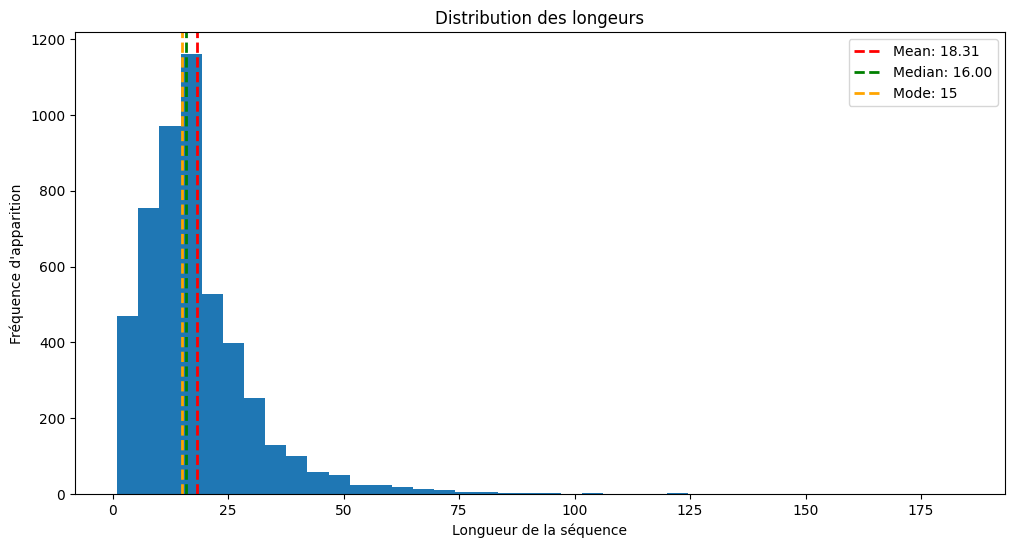

In [10]:

plt.figure(figsize=(12, 6))
plt.hist(
    x=df['text_size'],
    bins=40
)

sentences_sizes = df['text_size']
mean_val = sentences_sizes.mean()
median_val = sentences_sizes.median()
mode_val = sentences_sizes.mode()[0]

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(mode_val, color='orange', linestyle='--', linewidth=2, label=f'Mode: {mode_val}')

plt.legend()
plt.xlabel("Longueur de la séquence")
plt.ylabel("Fréquence d'apparition")
plt.title('Distribution des longeurs')
plt.show()

In [11]:
max_sentence_length=40

In [12]:
df = df[df['text_size'] <= max_sentence_length]

df_train_X: DataFrame
df_train_y: Series
df_test_X: DataFrame
df_test_y: Series

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(
    df, df['toxic'],
    stratify=df['toxic'],
    random_state=SEED,
    test_size=0.2
)

In [13]:

display(Markdown(
f"""
Répartition des jeux de données
- Entrainement : {len(df_train_y):n} messages avec {df_train_y.sum():n} considérés toxique ({df_train_y.sum()/len(df_train_y):.2%})
- Test : {len(df_test_y)} messages avec {df_test_y.sum():n} considérés toxique ({df_test_y.sum()/len(df_test_y):.2%})
"""))


Répartition des jeux de données
- Entrainement : 3782 messages avec 1852 considérés toxique (48.97%)
- Test : 946 messages avec 463 considérés toxique (48.94%)


# LSTM

In [14]:
# Tokenizer
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    output_sequence_length=max_sentence_length,
)

tokenizer.adapt(df['text'])

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7002 - loss: 0.5572 - val_accuracy: 0.8414 - val_loss: 0.3845
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9323 - loss: 0.1932 - val_accuracy: 0.8848 - val_loss: 0.3848
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9786 - loss: 0.0759 - val_accuracy: 0.9017 - val_loss: 0.3661
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9902 - loss: 0.0378 - val_accuracy: 0.9006 - val_loss: 0.4439
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9960 - loss: 0.0190 - val_accuracy: 0.9059 - val_loss: 0.4693
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9929 - loss: 0.0274 - val_accuracy: 0.8975 - val_loss: 0.4364


In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6663 - loss: 0.5701 - val_accuracy: 0.7918 - val_loss: 0.4460
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9133 - loss: 0.2297 - val_accuracy: 0.8932 - val_loss: 0.3293
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9736 - loss: 0.0868 - val_accuracy: 0.8975 - val_loss: 0.3850
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9900 - loss: 0.0363 - val_accuracy: 0.9006 - val_loss: 0.4030
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9889 - loss: 0.0373 - val_accuracy: 0.8985 - val_loss: 0.4917


In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(16, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6822 - loss: 0.5853 - val_accuracy: 0.8647 - val_loss: 0.3398
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9439 - loss: 0.1789 - val_accuracy: 0.8869 - val_loss: 0.3548
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9786 - loss: 0.0754 - val_accuracy: 0.8975 - val_loss: 0.3443
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9857 - loss: 0.0522 - val_accuracy: 0.8922 - val_loss: 0.3853


In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(16, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6721 - loss: 0.6072 - val_accuracy: 0.8541 - val_loss: 0.3618
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9342 - loss: 0.2164 - val_accuracy: 0.8932 - val_loss: 0.3235
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9802 - loss: 0.0806 - val_accuracy: 0.8901 - val_loss: 0.4431
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9926 - loss: 0.0432 - val_accuracy: 0.9049 - val_loss: 0.3392
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9942 - loss: 0.0270 - val_accuracy: 0.9059 - val_loss: 0.3995


In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(4, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(4)),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5489 - loss: 0.6890 - val_accuracy: 0.7685 - val_loss: 0.6697
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6653 - loss: 0.6010 - val_accuracy: 0.8668 - val_loss: 0.4622
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7856 - loss: 0.4570 - val_accuracy: 0.8827 - val_loss: 0.3454
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8496 - loss: 0.3936 - val_accuracy: 0.9038 - val_loss: 0.3093
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8871 - loss: 0.3201 - val_accuracy: 0.9070 - val_loss: 0.2869
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9040 - loss: 0.2849 - val_accuracy: 0.9027 - val_loss: 0.3008
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9223 - loss: 0.2494 - val_accuracy: 0.9186 - val_loss: 0.2527
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9334 - loss: 0.2254 - val_accu

In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Bidirectional, Dropout, Dense, Input

lstm = models.Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    Embedding(tokenizer.vocabulary_size(), max_sentence_length),
    Bidirectional(LSTM(4, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(4)),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5243 - loss: 0.6926 - val_accuracy: 0.6776 - val_loss: 0.6864
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6364 - loss: 0.6441 - val_accuracy: 0.8097 - val_loss: 0.5533
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7922 - loss: 0.5279 - val_accuracy: 0.8710 - val_loss: 0.4662
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8638 - loss: 0.4494 - val_accuracy: 0.8911 - val_loss: 0.4207
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8691 - loss: 0.4153 - val_accuracy: 0.8890 - val_loss: 0.4090
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8763 - loss: 0.3869 - val_accuracy: 0.8932 - val_loss: 0.4067
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8829 - loss: 0.3629 - val_accuracy: 0.8890 - val_loss: 0.3945
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8800 - loss: 0.3533 - val_accu

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.8911  |  Precision: 0.9545  |  Recall: 0.8164  |  F1: 0.8801



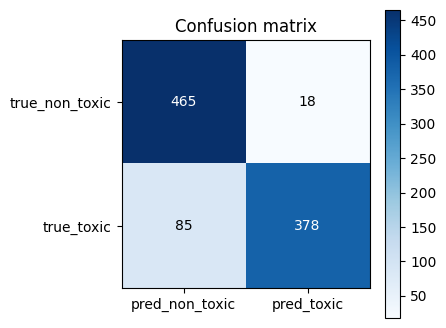

Classification report:

              precision    recall  f1-score   support

       False     0.8455    0.9627    0.9003       483
        True     0.9545    0.8164    0.8801       463

    accuracy                         0.8911       946
   macro avg     0.9000    0.8896    0.8902       946
weighted avg     0.8988    0.8911    0.8904       946



================================================================================  
10 exemples de MAUVAISE PRÉDICTION  
================================================================================  
Exemple 1:  
- Phrase: Je pense malgré tout que c'était ce qu'elle voulait, tu n'imagines même pas le nombre de salopes débectantes fantasmant sur le fait de se faire défoncer par des bougnoules tout en se débattant !
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 73.49% / probability: 0.2651)


Exemple 2:  
- Phrase: Par souci du Soleil et de la Lune, Zygarde possédera son cul par son piégeage dans un millier de vagues et de la tuer avec un millier de flèches!
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 66.50% / probability: 0.3350)


Exemple 3:  
- Phrase: Mort aux dictateurs et à leurs supporteurs!
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.41% / probability: 0.2059)


Exemple 4:  
- Phrase: Je pense malgré tout que c'était ce qu'elle voulait, tu n'imagines même pas le nombre de salopes débectantes fantasmant sur le fait de se faire défoncer par des bougnoules tout en se débattant !
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 73.49% / probability: 0.2651)


Exemple 5:  
- Phrase: Salut les fagots, mon nom est Jean, et je déteste tout célibataire un de vous.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.10% / probability: 0.2090)


Exemple 6:  
- Phrase: je pense que c est toi qui est plûtôt immature, vu comme tu te comporte...je pense que tu devrais lire la définition du mot  respect .
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 70.23% / probability: 0.2977)


Exemple 7:  
- Phrase: T as besoin d aller de pleindre aux  administrateurs  pour me mettre un avertissement sans savoir si je fais du vandalisme pur et simple trou d balle!???
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 75.02% / probability: 0.2498)


Exemple 8:  
- Phrase: Recommence à effacer les discustions et tu as mon poing sur ta gueulle !
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 70.00% / probability: 0.3000)


Exemple 9:  
- Phrase: Euh ok...parce que sinon je suis vraiment fonctionnaire, du coup selon toi je suis riche...?  
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 85.25% / probability: 0.8525)


Exemple 10:  
- Phrase: TOUS LES DEUX DES BOUFFONS
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.66% / probability: 0.2034)



In [48]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


p = lstm.predict(tf.convert_to_tensor(np.array(df_test_X['text']), dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = (df_test_y == 1).values.tolist()

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))



# Je veux 10 exemples de mauvaise prédiction et la phrases d'entrée
# Trouver les mauvaises prédictions
rand_i = np.random.random_integers(0, len(reals) - 1, len(reals))
wrong_predictions_indices = [int(i) for i in rand_i if reals[i] != preds[i]]

# Afficher les 10 premiers exemples de mauvaise prédiction

md_texts: list[str] = [
    "="*80 + "  ",
    "10 exemples de MAUVAISE PRÉDICTION  ",
    "="*80 + "  "
]

for count, idx in enumerate(wrong_predictions_indices[:10]):
    actual = "TOXIC" if reals[idx] else "NON-TOXIC"
    predicted = "TOXIC" if preds[idx] else "NON-TOXIC"
    prob = probs[idx]
    
    md_texts.append(f"Exemple {count + 1}:  ")
    md_texts.append(f"- Phrase: {df_test_X['text'].tolist()[idx]}")
    md_texts.append(f"- Réel: {actual}")
    md_texts.append(f"- Prédiction: {predicted} (confiance: {(prob if prob > 0.5 else 1 - prob):.2%} / probability: {prob:.4f})")
    md_texts.append(f"\n")

display(Markdown("\n".join(md_texts)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6532  |  Precision: 0.9800  |  Recall: 0.4537  |  F1: 0.6203



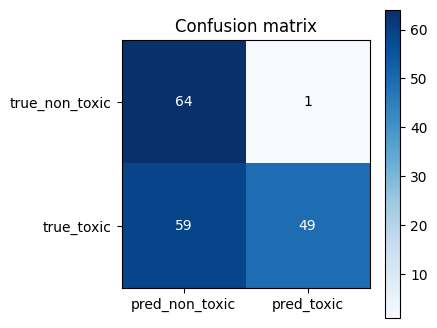

Classification report:

              precision    recall  f1-score   support

       False     0.5203    0.9846    0.6809        65
        True     0.9800    0.4537    0.6203       108

    accuracy                         0.6532       173
   macro avg     0.7502    0.7192    0.6506       173
weighted avg     0.8073    0.6532    0.6430       173



================================================================================  
10 exemples de MAUVAISE PRÉDICTION  
================================================================================  
Exemple 1:  
- Phrase: Cet article est vraiment mauvais, ne le lissez pas.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 80.03% / probability: 0.1997)


Exemple 2:  
- Phrase: Ton intelligence est un vrai farceur
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.24% / probability: 0.2076)


Exemple 3:  
- Phrase: Tu es en train de me rendre malade avec tes bêtises.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 67.38% / probability: 0.3262)


Exemple 4:  
- Phrase: Je ne veux plus entendre parler de toi. Tu es vraiment un raté.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 67.73% / probability: 0.3227)


Exemple 5:  
- Phrase: Ta famille est pleine de crapules
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.93% / probability: 0.2007)


Exemple 6:  
- Phrase: J'ai été trompé par cette publicité.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 80.07% / probability: 0.1993)


Exemple 7:  
- Phrase: Je déteste la façon dont ils gèrent leur entreprise.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.72% / probability: 0.2028)


Exemple 8:  
- Phrase: Je déteste la façon dont ils gèrent leur entreprise.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.72% / probability: 0.2028)


Exemple 9:  
- Phrase: Tu es trop bête pour comprendre ce que dit le proverbe.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 71.51% / probability: 0.2849)


Exemple 10:  
- Phrase: Ta vie est un échec total
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 79.44% / probability: 0.2056)



In [49]:
import generated_ai_comments

toxic_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxic_comments']
toxicless_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxicless_comments']

sentences_validation: list[str] = [
    *toxic_comments,
    *toxicless_comments
]

p = lstm.predict(tf.convert_to_tensor(sentences_validation, dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = [*[True] * len(toxic_comments), *[False] * len(toxicless_comments)]

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))

# Je veux 10 exemples de mauvaise prédiction et la phrases d'entrée
# Trouver les mauvaises prédictions
rand_i = np.random.random_integers(0, len(reals) - 1, len(reals))
wrong_predictions_indices = [i for i in rand_i if reals[i] != preds[i]]

# Afficher les 10 premiers exemples de mauvaise prédiction

md_texts: list[str] = [
    "="*80 + "  ",
    "10 exemples de MAUVAISE PRÉDICTION  ",
    "="*80 + "  "
]

for count, idx in enumerate(wrong_predictions_indices[:10]):
    actual = "TOXIC" if reals[idx] else "NON-TOXIC"
    predicted = "TOXIC" if preds[idx] else "NON-TOXIC"
    prob = probs[idx]
    
    md_texts.append(f"Exemple {count + 1}:  ")
    md_texts.append(f"- Phrase: {sentences_validation[idx]}")
    md_texts.append(f"- Réel: {actual}")
    md_texts.append(f"- Prédiction: {predicted} (confiance: {(prob if prob > 0.5 else 1 - prob):.2%} / probability: {prob:.4f})")
    md_texts.append(f"\n")

display(Markdown("\n".join(md_texts)))

---

In [50]:
keras.models.save_model(lstm, 'lstm_toxic_classifier_from_scratch.keras')

In [51]:
lstm_loaded: Sequential = keras.models.load_model('lstm_toxic_classifier_from_scratch.keras') # type: ignore

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.8911  |  Precision: 0.9545  |  Recall: 0.8164  |  F1: 0.8801



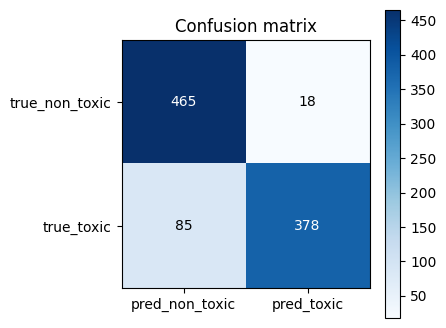

Classification report:

              precision    recall  f1-score   support

       False     0.8455    0.9627    0.9003       483
        True     0.9545    0.8164    0.8801       463

    accuracy                         0.8911       946
   macro avg     0.9000    0.8896    0.8902       946
weighted avg     0.8988    0.8911    0.8904       946



In [52]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


p = lstm_loaded.predict(tf.convert_to_tensor(np.array(df_test_X['text']), dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = (df_test_y == 1).values.tolist()

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))

In [54]:
lstm_loaded.predict(tf.convert_to_tensor(['le petit chat est gris', 'Tu es une ordure, on aurait du te faire piquer a la naissance']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.20768185],
       [0.9936691 ]], dtype=float32)